## Accessing MODIS vegetation data with the Planetary Computer STAC API

The planetary computer hosts several vegetation-related MODIS 6.1 products:

- Vegetation Indices
- Leaf Area Index/FPAR
- Gross Primary Productivity
- Net Evapotranspiration

For more information about the products themselves, check out the User Guides at the [bottom of this document](#user-guides).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
import odc.stac
import planetary_computer
import pystac_client
import rich.table

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Query for available data

MODIS is a global dataset with a variety of products available within each larger category (vegetation, snow, fire, temperature, and reflectance).
For example, there are two different collections for Vegetation Indices, one available at 500m resolution and the other at 250m resolution.
The [MODIS group](https://planetarycomputer.microsoft.com/dataset/group/modis) contains a complete listing of available collections.
Each collection's id is in the format `modis-{product}-061`, where `product` is the MODIS product id.
For example, the 500m Vegetation Indices collection is `modis-13A1-061`, and the 250m collection is `modis-13Q1-061`.
The `-061` suffix indicates that all of the MODIS collections are part of the [MODIS 6.1 update](https://atmosphere-imager.gsfc.nasa.gov/documentation/collection-61).

Let's find some Vegetation Indices data over the central valley of California in 2021.
We'll get four images, aiming for "representative" months: January, April, July, and October.

In [3]:
# Sacramento, CA
latitude = 38.6
longitude = -121.5
buffer = 1
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
year = "2021"
months = {
    "January": "01",
    "April": "04",
    "July": "07",
    "October": "10",
}
items = dict()

for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-13A1-061"],
        bbox=bbox,
        datetime=datetime,
    )
    items[name] = search.get_all_items()[0]

print(items)

{'January': <Item id=MYD13A1.A2021025.h08v05.061.2021042011101>, 'April': <Item id=MOD13A1.A2021113.h08v05.061.2021133131642>, 'July': <Item id=MOD13A1.A2021209.h08v05.061.2021226035904>, 'October': <Item id=MYD13A1.A2021297.h08v05.061.2021314025325>}


### Available assets

Each item has several available assets, including the original HDF file and a Cloud-optimized GeoTIFF of each subdataset.

In [4]:
item = items["January"]

t = rich.table.Table("Key", "Title")
for key, asset in items["January"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                                    ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf                                    │ Source data containing all bands                  │
│ metadata                               │ Federal Geographic Data Committee (FGDC) Metadata │
│ 500m_16_days_EVI                       │ 500m 16 days EVI                                  │
│ 500m_16_days_NDVI                      │ 500m 16 days NDVI                                 │
│ 500m_16_days_VI_Quality                │ VI quality indicators                             │
│ 500m_16_days_MIR_reflectance           │ Surface Reflectance Band 7                        │
│ 500m_16_days_NIR_reflectance           │ Surface Reflectance Band 2                        │
│ 500m_16_days_red_reflectance           │ Surface Reflectance Band 1                        │
│ 500m_16_days_blue_reflectance          │ Surface Reflectance Band 3                        │
│ 500m_16_days_sun_zenith_angle          │ Sun zenith angle of VI pixel                      │
│ 500m_16_days_pixel_reliability         │ Quality reliability of VI pixel                   │
│ 500m_16_days_view_zenith_angle         │ View zenith angle of VI Pixel                     │
│ 500m_16_days_relative_azimuth_angle    │ Relative azimuth angle of VI pixel                │
│ 500m_16_days_composite_day_of_the_year │ Day of year VI pixel                              │
│ tilejson                               │ TileJSON with default rendering                   │
│ rendered_preview                       │ Rendered preview                                  │
└────────────────────────────────────────┴───────────────────────────────────────────────────┘

### Loading the NDVI data

For this example, we'll visualize and compare the [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index). Let's grab each NDVI COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac). We'll also apply the scaling as defined by the `raster:bands` extension. The MODIS coordinate reference system is a [sinusoidal grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html), which means that views in a naïve XY raster look skewed. For visualization purposes, we reproject to a [spherical Mercator projection](https://wiki.openstreetmap.org/wiki/EPSG:3857) for intuitive, north-up visualization.

In [5]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="500m_16_days_NDVI",
    resolution=500,
    bbox=bbox,
)

raster = items["January"].assets["500m_16_days_NDVI"].extra_fields["raster:bands"]
data = data["500m_16_days_NDVI"] * raster[0]["scale"]
data

<xarray.DataArray '500m_16_days_NDVI' (time: 4, y: 570, x: 446)>
array([[[ 0.328 ,  0.328 ,  0.328 , ...,  0.1801,  0.1801,  0.1447],
        [ 0.3421,  0.3421,  0.3421, ...,  0.1793,  0.1793,  0.1659],
        [ 0.3475,  0.3723,  0.3772, ...,  0.1779,  0.1245,  0.1245],
        ...,
        [-0.3   , -0.3   , -0.3   , ...,  0.5779,  0.6112,  0.5442],
        [ 0.2205,  0.2205,  0.5283, ...,  0.5831,  0.5931,  0.6286],
        [-0.3   ,  0.3147,  0.588 , ...,  0.6148,  0.6125,  0.6125]],

       [[ 0.3048,  0.269 ,  0.269 , ...,  0.1271,  0.1271,  0.5162],
        [ 0.2865,  0.2865,  0.269 , ...,  0.436 ,  0.436 ,  0.436 ],
        [ 0.3183,  0.2999,  0.3096, ...,  0.1186,  0.4259,  0.4259],
        ...,
        [-0.3   , -0.3   , -0.3   , ...,  0.4879,  0.4992,  0.3813],
        [-0.3   , -0.3   ,  0.591 , ...,  0.6288,  0.6409,  0.5544],
        [-0.3   , -0.3   ,  0.6003, ...,  0.6608,  0.6409,  0.6409]],

       [[ 0.2843,  0.2435,  0.2435, ...,  0.6306,  0.6306,  0.6927],
        [ 0.2562,  0.2562,  0.2332, ...,  0.6466,  0.6466,  0.6927],
        [ 0.2556,  0.2541,  0.258 , ...,  0.5354,  0.5304,  0.6671],
        ...,
        [-0.3   , -0.3   ,  0.1783, ...,  0.2896,  0.3319,  0.3319],
        [ 0.2429,  0.2429, -0.3   , ...,  0.4388,  0.4581,  0.4438],
        [-0.3   , -0.3   ,  0.4658, ...,  0.5297,  0.5027,  0.5027]],

       [[ 0.444 ,  0.4985,  0.4985, ...,  0.4981,  0.4981,  0.5898],
        [ 0.4498,  0.4498,  0.4985, ...,  0.6344,  0.6344,  0.6179],
        [ 0.4771,  0.4771,  0.4946, ...,  0.4196,  0.4147,  0.4147],
        ...,
        [ 0.2697,  0.2697,  0.2697, ...,  0.4864,  0.5066,  0.5138],
        [ 0.2697,  0.2697,  0.2697, ...,  0.5255,  0.5152,  0.5138],
        [ 0.3559,  0.3559,  0.3559, ...,  0.5572,  0.5692,  0.5692]]])
Coordinates:
  * y            (y) float64 4.808e+06 4.807e+06 ... 4.524e+06 4.523e+06
  * x            (x) float64 -1.364e+07 -1.364e+07 ... -1.341e+07 -1.341e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-01-25 2021-04-23 ... 2021-10-24

### Displaying the data

Let's sanity-check ourselves by simply displaying the NDVI for each month.

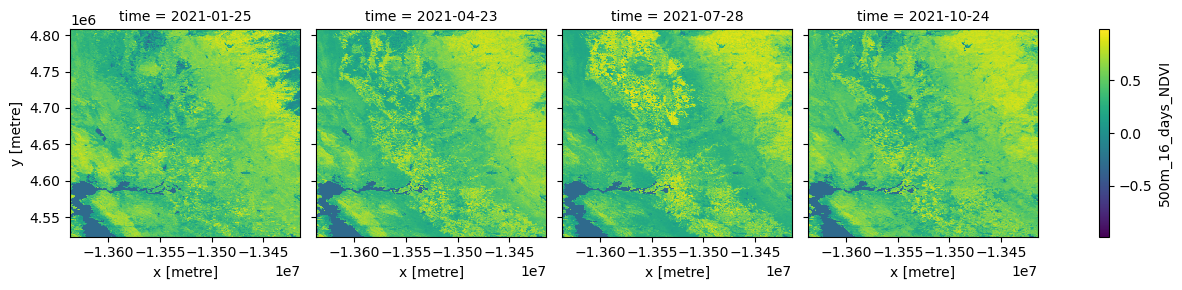

In [6]:
data.plot.imshow(cmap="viridis", col="time");

### Change detection

Now let's see how the NDVI changes from season to season.

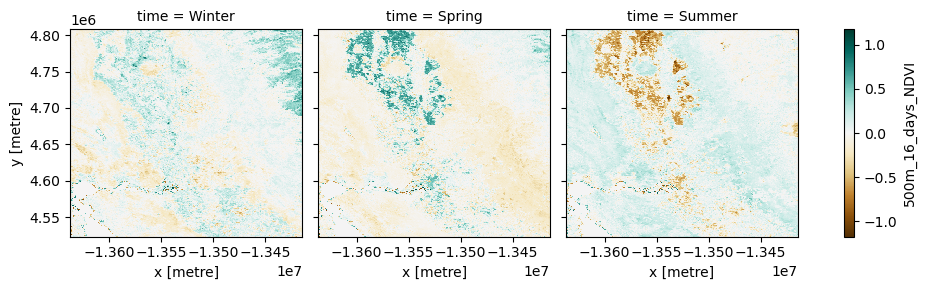

In [7]:
change = data.diff(dim="time").assign_coords(time=["Winter", "Spring", "Summer"])
change.plot.imshow(cmap="BrBG", col="time");

### User guides

- MOD13: Vegetation Indices: https://lpdaac.usgs.gov/documents/621/MOD13_User_Guide_V61.pdf
- MOD15: Leaf Area Index/FPAR: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf
- MOD16: Net Evapotranspiration: https://lpdaac.usgs.gov/documents/931/MOD16_User_Guide_V61.pdf
- MOD17: Gross Primary Productivity: https://lpdaac.usgs.gov/documents/972/MOD17_User_Guide_V61.pdf